# Multi-Threshold Analysis

In [31]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import pandas as pd
from scipy import stats
import seaborn as sns
import copy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn import tree

import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        plt.scatter(y_train,loo_train,label="LOO",color="black",marker=".",facecolor='none',s=200)
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

###removes zeros from the front of a number (as a string) to make them comparable regardless of source format
def remove_prefix_zeros(number):
    temp=number
    loop=True
    while(loop):
        if temp.startswith('0'):
            temp=temp[1:]
        else:
            loop=False
            
    try:
        temp=float(temp)
        temp=int(temp)
        temp=str(temp)
    except ValueError:
        temp=str(temp)
    
    return temp

In [58]:
comp_file = "descriptors" 
comp_sheet = "DFT_data" 
num_par = 190
par_start_col = 1   # 0-indexed
comp_num_samples = 1560 
y_label_col_comp = 0  # 0-indexed

exp_file = "threshold_data" 
exp_sheet = "threshold_data"
exp_num_samples = 51 
response_col = 7 # for minimum pyramidalization plot
y_label_col_exp = 2  # 0-indexed


# exp_file = "NS_monophos_rxn_output" 
# exp_sheet = "Trisub_cut_yields"
# exp_num_samples = 51 
# response_col = 8 # for Vbur(min) plot
# y_label_col_exp = 2  # 0-indexed

compinp = pd.read_excel("./InputData/"+comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))))
compinp.index = [remove_prefix_zeros(i) for i in compinp.index.map(str)]
expinp = pd.read_excel("./InputData/"+exp_file+".xlsx",exp_sheet,header=2,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)))
expinp.index = [remove_prefix_zeros(i) for i in expinp.index.map(str)]


xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]



X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]
y_labels_int = [int(x) for x in y_labels]
y_labels_dict = dict(zip(range(len(y_labels)),y_labels_int))

X = np.asarray(compinp.loc[y_labels],dtype=np.float)

del(compinp)
del(expinp)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))

n_samples before removing empty cells: 51
Removing 0 samples.
Shape X (all): (1544, 190)
Shape X (exp): (51, 190)
Shape y (exp): (51,)
Shape labels (exp): (51,)
First X (exp) cell: -0.0220091
Last X (exp) cell:  8.08628894
First y: -1.130760736711435
Last y:  0.19219685213067933
Last label exp: 5
Last label comp: ['1906' '1907' '1908']


In [50]:
correlation_cutoff = .8     # What R2 is considered to be correlated

### Find the correlation coefficients for each feature
corrmap = np.corrcoef(X.T)
binary_corrmap = corrmap > correlation_cutoff

In [51]:
### Really just a data container to keep a bunch of stuff relating to an individual threshold in one place
class Threshold:
    def __init__(self, dt, index, cut_value, operator, correlations):
        self.dt = dt
        self.index = index
        self.cut_value = cut_value
        self.operator = operator
        self.correlations = correlations
        
        self.feature_label = f'x{index+1}'
        self.feature_name = X_names[index]
        self.correlated_features = np.where(correlations==1)[0]
        self.added_accuracy = 0
    
    # Dependant on the global variable evaluation_method
    def __str__(self):
        return f'{self.feature_label} {self.feature_name} {self.operator} {self.cut_value:.3f} with Added {evaluation_method} of {self.added_accuracy:.3f}'    
    
### This is where most of the actual computations happen
### An object to hold a multiple thresholds and some methods to work with them
### Dependant on global variable X
class Hotspot:
    def __init__(self, thresholds,  ts=[], vs=[], evaluation_method='weighted_accuracy'):
        self.thresholds = []
               
        if(ts == []):
            ts = range(len(y))

        self.ts = ts
        self.vs = vs

        self.evaluation_method = evaluation_method
        self.__set_accuracy()
        self.initial_accuracy = self.accuracy
        for thresh in thresholds:
            self.add_threshold(thresh)
    
        self.threshold_indexes = self.__set_threshold_indexes()
        self.threshold_indexes.sort()
        self.correlated_features = self.__set_correlated_features()
            
    ### What comes out when you call the object as a string
    def __str__(self):
        output = f'Total {self.evaluation_method} with {len(self.thresholds)} thresholds: {self.accuracy:.3f}\n'
        output = output + f'Initial {self.evaluation_method} with no thresholds: {self.initial_accuracy:.3f}\n'
        output = output + 'Thresholds: \n'
        for thresh in self.thresholds:
            output = output + '\t' + str(thresh) + '\n'
        if(len(y_test)>0):
            output = output + f'Training set {self.evaluation_method} with {len(self.thresholds)} thresholds: {self.train_accuracy_dict[self.evaluation_method]:.3f}\n'
            output = output + f'Test set {self.evaluation_method} with {len(self.thresholds)} thresholds: {self.test_accuracy_dict[self.evaluation_method]:.3f}\n'
        return output
    
    ### If two hotspots use the same threshold parameters and have the same accuracy, they are considered equal
    def __eq__(self, other):
        output = self.threshold_indexes == other.threshold_indexes
        output = output and (self.accuracy == other.accuracy)
        return output
    
    ### Add a threshold to the hotspot and update accuracy
    def add_threshold(self, threshold):
        temp_accuracy = self.accuracy
        
        self.thresholds.append(threshold)
        self.__set_accuracy()
        self.__set_train_test_accuracy()
        added_accuracy = self.accuracy-temp_accuracy
        self.thresholds[-1].added_accuracy = added_accuracy
        
        self.threshold_indexes = self.__set_threshold_indexes()
        self.threshold_indexes.sort()
        self.correlated_features = self.__set_correlated_features()
       
    ### Bookeeping to update threshold_indexes
    def __set_threshold_indexes(self):
        indexes = []
        for thresh in self.thresholds:
            indexes.append(thresh.index)
        return indexes
    
    ### Bookeeping to update correlated_features
    def __set_correlated_features(self):
        features = []
        for thresh in self.thresholds:
            features.append(thresh.correlated_features)
        return features
    
    ### Returns the truth value of {value < or > cutoff}
    def __evaluate_threshold(self, value, op, cutoff):
        output = False
        if (op == '<'):
            if(value < cutoff):
                output = True
        elif(op == '>'):
            if(value > cutoff):
                output = True
        return output
        
    ### Evaluates if the point at a given index is inside or outside the hotspot
    ### Returns a bool of whether or not the point is inside the hotspot
    def __is_inside(self, index, X_space):
        bool_list = []
        for thresh in self.thresholds:
            value = X_space[index, thresh.index]
            bool_list.append(self.__evaluate_threshold(value, thresh.operator, thresh.cut_value))
        return all(bool_list)

    ### Sets self accuracy, f1, weighted accuracy and weighted f1 in the self.accuracy_dict dictionary
    def __set_accuracy(self):
        tp,tn,fp,fn = 0,0,0,0
        for i, hit in enumerate(y_class):
            if (hit == 1):
                if(self.__is_inside(i, X)):
                    tp = tp + 1
                else:
                    fn = fn + 1
            if (hit == 0):
                if(self.__is_inside(i, X)):
                    fp = fp + 1
                else:
                    tn = tn + 1
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = (2*tp) / (2*tp + fn + fp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        tp = tp * class_weight[1]
        tn = tn * class_weight[0]
        fp = fp * class_weight[0]
        fn = fn * class_weight[1]
        
        weighted_accuracy = (tp + tn) / (tp + tn + fp + fn)
        weighted_f1 = (2*tp) / (2*tp + fn + fp)
        
        ### Sets self.accuracy to the accuracy statistic in evaluation_method
        self.accuracy_dict = {'accuracy':accuracy, 'weighted_accuracy':weighted_accuracy, 'f1':f1, 'weighted_f1':weighted_f1,
                             'precision':precision, 'recall':recall}
        self.accuracy = self.accuracy_dict[self.evaluation_method]
    
    ### Sets training and test accuracy dictionaries with all the accuracy stats
    def __set_train_test_accuracy(self):
        tp,tn,fp,fn = 0,0,0,0
        for i, hit in enumerate(y_class_train):
            if (hit == 1):
                if(self.__is_inside(i, X_train)):
                    tp = tp + 1
                else:
                    fn = fn + 1
            if (hit == 0):
                if(self.__is_inside(i, X_train)):
                    fp = fp + 1
                else:
                    tn = tn + 1
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1 = (2*tp) / (2*tp + fn + fp)

        tp = tp * class_weight[1]
        tn = tn * class_weight[0]
        fp = fp * class_weight[0]
        fn = fn * class_weight[1]
        
        weighted_accuracy = (tp + tn) / (tp + tn + fp + fn)
        weighted_f1 = (2*tp) / (2*tp + fn + fp)
        
        ### Sets self.accuracy to the accuracy statistic in evaluation_method
        self.train_accuracy_dict = {'accuracy':accuracy, 'weighted_accuracy':weighted_accuracy, 'f1':f1, 'weighted_f1':weighted_f1}
        
        if(len(y_class_test) > 0):
            tp,tn,fp,fn = 0,0,0,0
            for i, hit in enumerate(y_class_test):
                if (hit == 1):
                    if(self.__is_inside(i, X_test)):
                        tp = tp + 1
                    else:
                        fn = fn + 1
                if (hit == 0):
                    if(self.__is_inside(i, X_test)):
                        fp = fp + 1
                    else:
                        tn = tn + 1

            accuracy = (tp + tn) / (tp + tn + fp + fn)
            f1 = (2*tp) / (2*tp + fn + fp)

            tp = tp * class_weight[1]
            tn = tn * class_weight[0]
            fp = fp * class_weight[0]
            fn = fn * class_weight[1]

            weighted_accuracy = (tp + tn) / (tp + tn + fp + fn)
            weighted_f1 = (2*tp) / (2*tp + fn + fp)
        else:
            accuracy = 0
            weighted_accuracy = 0
            f1 = 0
            weighted_f1 = 0
        
        ### Sets self.accuracy to the accuracy statistic in evaluation_method
        self.test_accuracy_dict = {'accuracy':accuracy, 'weighted_accuracy':weighted_accuracy, 'f1':f1, 'weighted_f1':weighted_f1}

    ### For internal use to get the chemical space after applying a threshold
    def __apply_threshold(self, thresh, X_current, y_current):
        if(thresh.operator == '<'):
            mask_prop = X_current[:,thresh.index] < thresh.cut_value
        elif(thresh.operator == '>'):
            mask_prop = X_current[:,thresh.index] > thresh.cut_value
        else:
            print('THERE IS A PROBLEM HERE')
        X_sel,y_sel = X_current[mask_prop],y_current[mask_prop]
        return X_sel,y_sel
    
    ### Returns a cut down X, y based on the hotspot
    def get_hotspot_space(self):
        X_out = X
        y_out = y
        for thresh in self.thresholds:
            X_out, y_out = self.__apply_threshold(thresh, X_out, y_out)
        return X_out, y_out
    
    ### Returns a list of all ligands in the hotspot
    ### {style} should be 'index' or 'id' depending on what format you want out
    def get_hotspot_ligands(self, style='index'):
        output = []
        ### Iterates through each ligand by index and if it's within the hotspot appends the ligand ID to output
        if(style=='index'):
            for i in range(len(y)):
                if(self.__is_inside(i,X)):
                    output.append(i)
        elif(style=='id'):
            for i in range(len(y)):
                if(self.__is_inside(i,X)):
                    output.append(y_labels_dict[i])
        return output
    
    ### Print the hotspot in 3d space
    def plot_3d(self, subset='all', coloring='scaled'):
        %matplotlib notebook
        #print('AT LEAST THIS IS WORKING')
        x_col,y_col,z_col = self.thresholds[0].index, self.thresholds[1].index, self.thresholds[2].index
        
        ### This section auto-scales the plot
        x_min = min(X[:,x_col])
        x_max = max(X[:,x_col])
        y_min = min(X[:,y_col])
        y_max = max(X[:,y_col])
        z_min = min(X[:,z_col]) 
        z_max = max(X[:,z_col])

        dx = abs(x_min-x_max)
        dy = abs(y_min-y_max)
        dz = abs(z_min-z_max)

        x_min = x_min - abs(dx*0.05)
        x_max = x_max + abs(dx*0.05)
        y_min = y_min - abs(dy*0.05)
        y_max = y_max + abs(dy*0.05)
        z_min = z_min - abs(dz*0.05)
        z_max = z_max + abs(dz*0.05)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(projection = '3d')

        ### Sets the points to plot based on {subset}
        if(subset=='all'):
            X_space = X
            y_scaled = y
            y_binary = y_class
        elif(subset=='train'):
            X_space = X[ts]
            y_scaled = y_train
            y_binary = y_class_train
        elif(subset=='test'):
            X_space = X[vs]
            y_scaled = y_test
            y_binary = y_class_test
        else:
            print('---Bad subset input---\n')
            
        
        ### Changes how the points are colored, controlled by the {coloring} variable
        if(coloring=='scaled'):
            mapping_cl = y_scaled
            cMap_cl = 'coolwarm'
        elif(coloring=='binary'):
            mapping_cl = y_binary
            cMap_cl = 'Oranges'

        ax.scatter(X_space[:,x_col], X_space[:,y_col], X_space[:,z_col],c=mapping_cl,cmap=cMap_cl,alpha=0.95,marker="s",s=20, edgecolors='k') 
            
        ### Plots the z-axis threshold
        temp_x = np.linspace(x_min, x_max, num=10)
        temp_y = np.linspace(y_min, y_max, num=10)
        temp_x, temp_y = np.meshgrid(temp_x, temp_y)
        temp_z = self.thresholds[2].cut_value + 0*temp_x + 0*temp_y
        ax.plot_surface(temp_x, temp_y, temp_z, alpha=0.15, color='gray')
        
        ### Plots the x-axis threshold
        temp_y = np.linspace(y_min, y_max, num=10)
        temp_z = np.linspace(z_min, z_max, num=10)
        temp_z, temp_y = np.meshgrid(temp_z, temp_y)
        temp_x = self.thresholds[0].cut_value + 0*temp_z + 0*temp_y
        ax.plot_surface(temp_x, temp_y, temp_z, alpha=0.15, color='gray') 
        
        ### Plot the y-axis threshold
        temp_x = np.linspace(x_min, x_max, num=10)
        temp_z = np.linspace(z_min, z_max, num=10)
        temp_x, temp_z = np.meshgrid(temp_x, temp_z)
        temp_y = self.thresholds[1].cut_value + 0*temp_x + 0*temp_z
        ax.plot_surface(temp_x, temp_y, temp_z, alpha=0.15, color='gray')
        
        plt.xticks(fontsize=10) 
        plt.yticks(fontsize=10)

        
        ax.set_xlabel(f'{self.thresholds[0].feature_label} {self.thresholds[0].feature_name}',fontsize=12.5)
        ax.set_ylabel(f'{self.thresholds[1].feature_label} {self.thresholds[1].feature_name}',fontsize=12.5)
        ax.set_zlabel(f'{self.thresholds[2].feature_label} {self.thresholds[2].feature_name}',fontsize=12.5)
        plt.locator_params(axis='y', nbins=8)

        ax.set_xlim(x_min,x_max)
        ax.set_ylim(y_min,y_max)
        ax.set_zlim(z_min, z_max)

        plt.tight_layout()
        plt.show()  
        
    ### Print the hotspot in 2d space
    def plot_2d(self, subset='all', coloring='scaled', output_label='Yield %'):
        %matplotlib inline
        
        x_col,y_col = self.thresholds[0].index, self.thresholds[1].index

        ### This section auto-scales the plot
        x_min = min(X[:,x_col])
        x_max = max(X[:,x_col])
        y_min = min(X[:,y_col])
        y_max = max(X[:,y_col])

        dx = abs(x_min-x_max)
        dy = abs(y_min-y_max)

        x_min = x_min - abs(dx*0.05)
        x_max = x_max + abs(dx*0.05)
        y_min = y_min - abs(dy*0.05)
        y_max = y_max + abs(dy*0.05)
        
        ### Sets the points to plot based on {subset}
        if(subset=='all'):
            X_space = X
            y_scaled = y
            y_binary = y_class
        elif(subset=='train'):
            X_space = X[ts]
            y_scaled = y_train
            y_binary = y_class_train
        elif(subset=='test'):
            X_space = X[vs]
            y_scaled = y_test
            y_binary = y_class_test
        else:
            print('---Bad subset input---\n')
            
        
        ### Changes how the points are colored, controlled by the {coloring} variable
        if(coloring=='scaled'):
            mapping_cl = y_scaled
            cMap_cl = 'coolwarm'
        elif(coloring=='binary'):
            mapping_cl = y_binary
            cMap_cl = 'Oranges'
        
        ### Axis setup
        plt.figure(figsize=(12, 8))
        plt.xlabel(f'{self.thresholds[0].feature_label} {self.thresholds[0].feature_name}',fontsize=15)
        plt.ylabel(f'{self.thresholds[1].feature_label} {self.thresholds[1].feature_name}',fontsize=15)
        plt.xticks(fontsize=18)
        plt.xlim(x_min, x_max)
        plt.locator_params(axis='x', nbins=5)
        plt.yticks(fontsize=18)
        plt.ylim(y_min, y_max)
        plt.locator_params(axis='y', nbins=4)

        ### This is where you choose which descriptors to plot
        plt.scatter(X_space[:,x_col],X_space[:,y_col], c=mapping_cl,cmap=cMap_cl, edgecolor='black', s=100)  
        
        ### Set the gradient bar on the side
        if(coloring == 'scaled'):
            cbar = plt.colorbar()
            cbar.set_label(output_label, rotation=90,size=18)
            if('yield' in output_label or 'Yield' in output_label):
                plt.clim(vmin=0, vmax=100)
            else:
                plt.clim(vmin=0, vmax=max(y_scaled)*1.05)

        plt.axhline(y=self.thresholds[1].cut_value, color='r', linestyle='--')
        plt.axvline(x=self.thresholds[0].cut_value, color='r', linestyle='--')

        plt.show() 
        
    ### Print the hotspot in 1-descriptor space
    def plot_1d(self, subset='all', coloring='scaled', output_label='Yield %'):
        %matplotlib inline
        
        x_col = self.thresholds[0].index

        ### This section auto-scales the plot
        x_min = min(X[:,x_col])
        x_max = max(X[:,x_col])
        y_min = min(y)
        y_max = max(y)

        dx = abs(x_min-x_max)
        dy = abs(y_min-y_max)

        x_min = x_min - abs(dx*0.05)
        x_max = x_max + abs(dx*0.05)
        y_min = y_min - abs(dy*0.05)
        y_max = y_max + abs(dy*0.05)
        
        ### Sets the points to plot based on {subset}
        if(subset=='all'):
            X_space = X
            y_scaled = y
            y_binary = y_class
        elif(subset=='train'):
            X_space = X[ts]
            y_scaled = y_train
            y_binary = y_class_train
        elif(subset=='test'):
            X_space = X[vs]
            y_scaled = y_test
            y_binary = y_class_test
        else:
            print('---Bad subset input---\n')
            
        
        ### Changes how the points are colored, controlled by the {coloring} variable
        if(coloring=='scaled'):
            mapping_cl = y_scaled
            cMap_cl = 'winter'
        elif(coloring=='binary'):
            mapping_cl = y_binary
            cMap_cl = 'Oranges'
        
        ### Axis setup
        plt.figure(figsize=(12, 8))
        plt.xlabel(f'{self.thresholds[0].feature_label} {self.thresholds[0].feature_name}',fontsize=15)
        plt.ylabel(output_label,fontsize=15)
        plt.xticks(fontsize=18)
        plt.xlim(x_min, x_max)
        plt.locator_params(axis='x', nbins=5)
        plt.yticks(fontsize=18)
        plt.ylim(y_min, y_max)
        plt.locator_params(axis='y', nbins=4)

        ### This is where you choose which descriptors to plot
        plt.scatter(X_space[:,x_col],y_scaled, c=mapping_cl,cmap=cMap_cl, edgecolor='black', s=100)  
        
        ### Set the gradient bar on the side
        if(coloring == 'scaled'):
            cbar = plt.colorbar()
            cbar.set_label(output_label, rotation=90,size=18)
            if('yield' in output_label or 'Yield' in output_label):
                plt.clim(vmin=0, vmax=100)
            else:
                #plt.clim(vmin=0, vmax=max(y_scaled)*1.05)          
                plt.clim(vmin=min(y_scaled)*1.05, vmax=max(y_scaled)*1.05)
        plt.axvline(x=self.thresholds[0].cut_value, color='r', linestyle='--')

        plt.show() 
       
    ### plots the hotspot in 2d or 3d depending on how many thresholds are present
    ### subset should be 'all', 'test', or 'train'
    ### coloring should be 'scaled' or 'binary' --- only works on 3D at the moment
    def plot(self, subset='all', coloring='scaled', output_label='Yield %'):
        if(len(self.thresholds)==1):
            self.plot_1d(subset, coloring, output_label)
        elif(len(self.thresholds)==2):
            self.plot_2d(subset, coloring, output_label)
        elif(len(self.thresholds)==3):
            self.plot_3d(subset, coloring)
      
    ### Gives a bool column of which ligands are inside the hotspot
    ### {X_all} is the space you're expanding to, likely the X_all variable from reading in data
    ### Returns a list of bools
    def expand(self, X_all):
        bool_list = [self.__is_inside(i, X_all) for i in range(len(X_all))]
        return bool_list
    
    def remake(self):
        return Hotspot(self.thresholds, self.ts, self.vs, self.evaluation_method)
    
    ### returns a list of all hotspots that can be made from colinear parameters
    def colinear_hotspots(self):
        hotspot_list = []
        ### Iterates through each of the correlated sets
        if(len(self.correlated_features) == 3):
            for colinear_1 in self.correlated_features[0]:
                for colinear_2 in self.correlated_features[1]:
                    for colinear_3 in self.correlated_features[2]:
                        hotspot_list.append([colinear_1, colinear_2, colinear_3])
        else:
            for colinear_1 in self.correlated_features[0]:
                for colinear_2 in self.correlated_features[1]:
                    hotspot_list.append([colinear_1, colinear_2])

        hotspot_list.remove(self.threshold_indexes)
        return hotspot_list
    
    ### Prints all the relevant stats
    def print_stats(self):
        a_accuracy = self.accuracy_dict['accuracy']
        a_weighted_accuracy = self.accuracy_dict['weighted_accuracy']
        a_f1 = self.accuracy_dict['f1']
        a_weighted_f1 = self.accuracy_dict['weighted_f1']
        a_precision = self.accuracy_dict['precision']
        a_recall = self.accuracy_dict['recall']

        tr_accuracy = self.train_accuracy_dict['accuracy']
        tr_weighted_accuracy = self.train_accuracy_dict['weighted_accuracy']
        tr_f1 = self.train_accuracy_dict['f1']
        tr_weighted_f1 = self.train_accuracy_dict['weighted_f1']
        
        te_accuracy = self.test_accuracy_dict['accuracy']
        te_weighted_accuracy = self.test_accuracy_dict['weighted_accuracy']
        te_f1 = self.test_accuracy_dict['f1']
        te_weighted_f1 = self.test_accuracy_dict['weighted_f1']
        
        print('                    all    train    test')
        print(f'         Accuracy: {a_accuracy:.3f}   {tr_accuracy:.3f}   {te_accuracy:.3f}')
        print(f'Weighted Accuracy: {a_weighted_accuracy:.3f}   {tr_weighted_accuracy:.3f}   {te_weighted_accuracy:.3f}')
        print(f'               F1: {a_f1:.3f}   {tr_f1:.3f}   {te_f1:.3f}')
        print(f'      Weighted F1: {a_weighted_f1:.3f}   {tr_weighted_f1:.3f}   {te_weighted_f1:.3f}\n')
        print(f'        Precision: {a_precision:.3}')
        print(f'           Recall: {a_recall:.3f}')
    
### Accepts {X_space} a matrix of parameters, {y_space} a list of outputs, {y_cut} a cutoff value for classifying success, and class_weight
### Returns a list of threshold objects, one for each parameter in X
def threshold_generation(X_space, binary_y_space, class_weight, feature=-1):
    if(feature==-1):
        features = range(X_space.shape[1])
    else:
        features = feature
    
    all_thresholds = []
    for f_ind in features:
        dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X_space[:,f_ind].reshape(-1, 1), binary_y_space)

        #Turns the dt into a Threshold object
        if(len(dt.tree_.children_left)>1):            
            ### If the amount of hits in the left subtree is greater than hits in the right subtree
            if(dt.tree_.value[1][0][1] > dt.tree_.value[2][0][1]):
                 operator = '<'
            else:
                operator = '>'
        else:
            operator = '>'
            
        temp_threshold = Threshold(
            dt, 
            f_ind, 
            dt.tree_.threshold[0], 
            operator, 
            correlations=binary_corrmap[f_ind,:]
        )

        all_thresholds.append(temp_threshold)
    
    return all_thresholds

### returns the more accurate {percentage} of the input {hotspots} judged by the accurcy method {method}
def prune_hotspots(hotspots, percentage, method):
    accuracy_list=[]
    for hs in hotspots:
        accuracy_list.append(hs.accuracy_dict[method])

    cut = np.percentile(accuracy_list, 100-percentage)
    
    hs_out=[]
    for hs in hotspots:
        if(hs.accuracy_dict[method]>cut):
            hs_out.append(hs)
    
    return hs_out

### Accepts {hs_list} a list of hotspots and {n} the number of best hotspots desired
### Returns a list of the {n} most accurate hotspots from the list
def find_best_hotspots(hs_list, n, method):
    best_hotspots = []
    test = 0
    
    ### Repeat until you have n hotspots
    for i in range(n):
        best_accuracy = 0
        best_hs = 0
        
        ### Check each hotspot in the list to see if it's the next best
        for hs in hs_list:
            if((hs.accuracy_dict[method] > best_accuracy and hs not in best_hotspots)):
                best_accuracy = hs.accuracy_dict[method]
                best_hs = hs

        if(type(best_hs) == int):
            continue
        else:
            best_hotspots.append(best_hs)
            hs_list.remove(best_hs)

    return best_hotspots

### Accepts {hs} a hotspot, {n} number of new hotspots, and class_weight
### Returns a list of {n} hotspots each with an additional threshold
def hs_next_thresholds(hs, X_space, binary_y_space, class_weight):
    
    ### Makes all possible hotspots by adding one threshold
    all_hotspots = []
    for f_ind in range(X_space.shape[1]):
        dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X_space[:,f_ind].reshape(-1, 1), binary_y_space)

        #Turns the dt into a Threshold object
        if(len(dt.tree_.children_left)>1):            
            ### If the amount of hits in the left subtree is greater than hits in the right subtree
            if(dt.tree_.value[1][0][1] > dt.tree_.value[2][0][1]):
                 operator = '<'
            else:
                operator = '>'
        else:
            operator = '>'
            
            
        temp_threshold = Threshold(
            dt, 
            f_ind, 
            dt.tree_.threshold[0], 
            operator, 
            correlations=binary_corrmap[f_ind,:]
        )

        temp_hs = copy.deepcopy(hs)
        temp_hs.add_threshold(temp_threshold)
        all_hotspots.append(temp_hs)

    return all_hotspots

### Train/Test split function to consolidate
def train_test_splits(X_sel,y_sel,labels_sel,split, test_ratio, randomstate=0):
    if split == "random":
        X_train, X_test, y_train, y_test = train_test_split(
            X_sel, y_sel, random_state=randomstate+4, test_size=test_ratio)    
        TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
        VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

    elif split == "ks":
        import kennardstonealgorithm as ks
        TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
        X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]

        TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
        VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

    elif split == "y_equidist":
        no_extrapolation = True

        import kennardstonealgorithm as ks
        if no_extrapolation:
            minmax = [np.argmin(y_sel),np.argmax(y_sel)]
            y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
            y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]

            # indices relative to y_ks:
            VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
            # indices relative to y_sel:
            TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
            VS_ = sorted([y_ks_indices[i] for i in VS_ks])

        else:
            VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))

        X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]

        # indices relative to y
        TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
        VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

    elif split == "none":
        TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
        X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]

    else: 
        raise ValueError("split option not recognized")
        
    print("TS: {}".format(TS))
    print("VS: {}".format(VS))
    print("y_mean TS: {:.3f}".format(np.mean(y_train)))
    print("y_mean VS: {:.3f}".format(np.mean(y_test)))
    print("Shape X_train: {}".format(X_train.shape))
    print("Shape X_test:  {}".format(X_test.shape))   
    plt.figure(figsize=(5, 5))
    hist,bins = np.histogram(y_sel,bins="auto")#"auto"
    plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
    plt.hist(y_test, bins, alpha=0.5, label='y_test')
    plt.xlabel("y",fontsize=20)
    plt.ylabel("N samples",fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

    return X_train,y_train,X_test,y_test,TS,VS

def get_parameters(hs_list, filename, n):
    cols = []
    for i in range(len(hs_list[0].thresholds)):
        cols.append(f'Parameter {i}')
    df = DataFrame(columns=cols)
    for hs in hs_list:
        df.append(hs.threshold_indexes)
    df.to_csv(filename)

# Train/test split

TS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
VS: []
y_mean TS: -0.239
y_mean VS: nan
Shape X_train: (45, 190)
Shape X_test:  (0, 190)


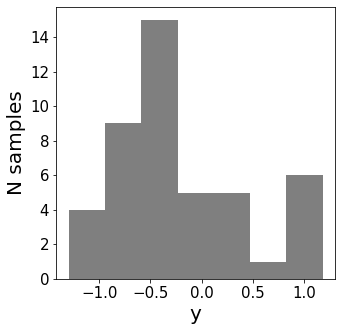

In [52]:
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

split = "none"
test_ratio = 0.3 

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y_sel, random_state=randomstate+4, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    TS = [3, 4, 5, 8, 13, 14, 21, 23, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 43, 44, 45, 46, 47, 54, 55, 56, 57, 58, 61, 62, 64, 65]
    #TS = []
    VS = [1, 11, 12, 15, 22, 24, 25, 28, 30, 32, 40, 42, 63] 
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    #VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    #TS = [i for i in range(X.syhape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == 'define_ligIndex':
    #This one uses ligand ID number instead of array index
    TS = []
    VS = [3,12,24,25,31,32]
    
    TS = [y_labels_dict[x] for x in TS]
    VS = [y_labels_dict[x] for x in VS]
    
    if(len(VS)==0):
        VS = [x for x in range(X.shape[0]) if x not in TS]
    if(len(TS)==0):
        TS = [x for x in range(X.shape[0]) if x not in VS]

    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
        
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "stratify":
    X_train, X_test, y_train, y_test = stratified_split(X_sel,y_sel,test_size=test_ratio)   
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [53]:
# Cutoff for what counts as a hit
y_cut = 0 # for minimum pyramidalization plot
#y_cut = 0.4 # for Vbur(min) plot

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# How many threshold dimensions do you want?
n_thresholds = 1


# What percentage of hotspots to take through to each subsequent step
# High percentage (>20) can take a while to run if you're getting a 3d hotspot
# I've seen the same top 5 results at 5% and 20%, so it probably doesn't matter too much
percentage = 30

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'accuracy'

# Set to True if you want a hotspot of low output results
low_is_good = False

# How many models do you want at the end?
n_models = 100

In [56]:
### Set up y_class, the binary list of which y values are above y_cut
if(low_is_good):
    y_class = np.array([0 if i > y_cut else 1 for i in y])
else:
    y_class = np.array([0 if i < y_cut else 1 for i in y])
y_class_train = y_class[TS]
y_class_test = y_class[VS]

### Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = threshold_generation(X_train, y_class_train, class_weight)
all_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot([thresh], TS, VS, evaluation_method)
    all_hotspots.append(temp_hs)

print(len(all_hotspots))    
### Cut down to the best {percentage} hotspots
all_hotspots = prune_hotspots(all_hotspots, percentage, evaluation_method)
print(len(all_hotspots))

### Add more thresholds, pruning after each step to keep memory reasonable
for i in range(n_thresholds - 1):
    new_hotspots = []
    for hs in all_hotspots:
        new_hotspots.extend(hs_next_thresholds(hs, X_train, y_class_train, class_weight))
    all_hotspots = new_hotspots
    del (new_hotspots)
    print(len(all_hotspots))
    all_hotspots = prune_hotspots(all_hotspots, percentage, evaluation_method)
    print(len(all_hotspots))
    
### Cut down to the top n hotspots
best_hotspots = find_best_hotspots(all_hotspots, n_models, evaluation_method)
del(all_hotspots)
print(len(best_hotspots))
    
### print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:10]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

190
55
55
Hotspot Index: 0
Total accuracy with 1 thresholds: 0.844
Initial accuracy with no thresholds: 0.311
Thresholds: 
	x87 vbur_vbur_min > 50.961 with Added accuracy of 0.533

                    all    train    test
         Accuracy: 0.844   0.844   0.000
Weighted Accuracy: 0.906   0.906   0.000
               F1: 0.788   0.788   0.000
      Weighted F1: 0.942   0.942   0.000

        Precision: 0.684
           Recall: 0.929

**********************************

Hotspot Index: 1
Total accuracy with 1 thresholds: 0.844
Initial accuracy with no thresholds: 0.311
Thresholds: 
	x90 vbur_vbur_vburminconf > 50.961 with Added accuracy of 0.533

                    all    train    test
         Accuracy: 0.844   0.844   0.000
Weighted Accuracy: 0.906   0.906   0.000
               F1: 0.788   0.788   0.000
      Weighted F1: 0.942   0.942   0.000

        Precision: 0.684
           Recall: 0.929

**********************************

Hotspot Index: 2
Total accuracy with 1 thresholds: 0.8

Total accuracy with 1 thresholds: 0.745
Initial accuracy with no thresholds: 0.627
Thresholds: 
	x87 vbur_vbur_min < 58.207 with Added accuracy of 0.118



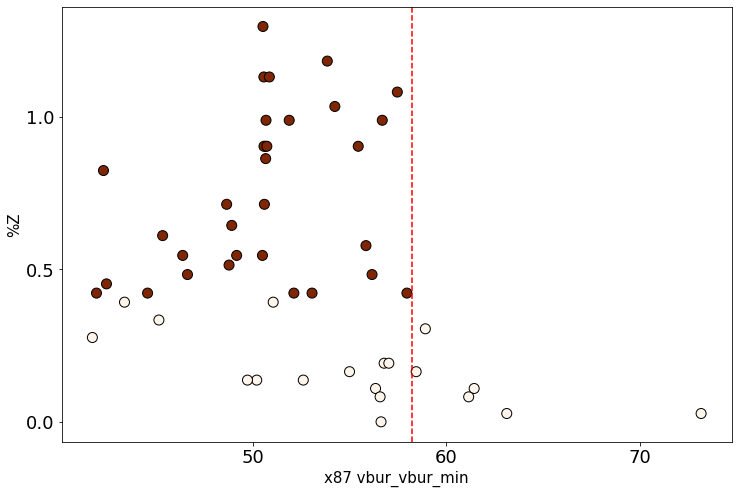

TypeError: 'subset' is an invalid keyword argument for print()

In [46]:
# Print the Vbur(min) plot
hotspot_number = 6

%matplotlib notebook
print(best_hotspots[hotspot_number])
from matplotlib import cm
### You can change the coloring to either 'scaled' or 'binary'
### subset can be 'all', 'training', or 'test'
best_hotspots[hotspot_number].plot(subset='all', coloring='binary', output_label='%Z')
print(subset='all')

Total accuracy with 1 thresholds: 0.778
Initial accuracy with no thresholds: 0.311
Thresholds: 
	x77 pyr_P_min < 0.913 with Added accuracy of 0.467



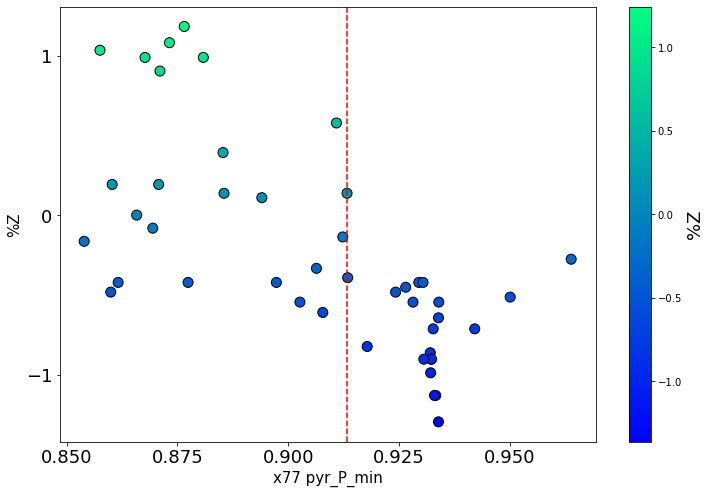

TypeError: 'subset' is an invalid keyword argument for print()

In [57]:
# Print the minimum pyramidalization plot
hotspot_number = 9

%matplotlib notebook
print(best_hotspots[hotspot_number])
from matplotlib import cm
### You can change the coloring to either 'scaled' or 'binary'
### subset can be 'all', 'training', or 'test'
best_hotspots[hotspot_number].plot(subset='all', coloring='scaled', output_label='%Z')
print(subset='all')